In [87]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [88]:
# data = pd.read_csv(r"processedData.csv")
data = pd.read_csv("data/sp500_stocks.csv")

data=data[data['Symbol']=='MMM']
data.drop(['Symbol'], axis=1, inplace=True)
date_column='Date'
target_column='Close'
data

,Date,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,46.422302,69.414719,69.774246,69.122070,69.473244,3640265.0
1,2010-01-05,46.131523,68.979935,69.590302,68.311035,69.230766,3405012.0
2,2010-01-06,46.785759,69.958191,70.735786,69.824417,70.133781,6301126.0
3,2010-01-07,46.819294,70.008362,70.033447,68.662209,69.665550,5346240.0
4,2010-01-08,47.149204,70.501671,70.501671,69.648827,69.974915,4073337.0
...,...,...,...,...,...,...,...
3605,2024-05-01,98.440002,98.440002,99.699997,97.279999,98.099998,11062600.0
3606,2024-05-02,96.809998,96.809998,98.400002,96.650002,97.959999,6317100.0
3607,2024-05-03,97.150002,97.150002,98.190002,96.839996,97.580002,4818500.0
3608,2024-05-06,96.589996,96.589996,97.750000,96.540001,97.089996,4329500.0


In [89]:
data['Date'] = pd.to_datetime(data['Date'])
monthly_avg = data.groupby(pd.Grouper(key='Date', freq='M')).mean()
monthly_avg.reset_index(inplace=True)
monthly_avg['Date'] = monthly_avg['Date'].dt.year.astype(str) + '-01-01'
data=monthly_avg.copy()

In [90]:
data

,Date,Adj Close,Close,High,Low,Open,Volume
0,2010-01-01,46.409345,69.395353,70.013202,68.794226,69.567418,4.734152e+06
1,2010-01-01,44.824470,66.802940,67.274248,66.134042,66.814822,4.722337e+06
2,2010-01-01,46.098352,68.392467,68.796350,67.871529,68.277592,4.735437e+06
3,2010-01-01,48.091365,71.349340,71.802039,70.783962,71.270903,5.490608e+06
4,2010-01-01,47.170385,69.780935,70.843227,68.449833,70.097408,6.552501e+06
...,...,...,...,...,...,...,...
168,2024-01-01,86.860169,86.860169,87.838429,85.963529,87.148032,5.641037e+06
169,2024-01-01,77.616639,77.616639,78.110369,76.964465,77.602425,4.631181e+06
170,2024-01-01,84.071907,84.071907,84.895067,83.097826,83.770067,8.078986e+06
171,2024-01-01,92.267728,92.267728,93.245454,91.181819,92.221363,5.082609e+06


In [91]:
# data.to_csv("processedData.csv",index=False)
# data = pd.read_csv("processedData.csv")
# data

## Pre Processing

In [93]:
# data = pd.read_csv(r"processedData.csv")
date_column='Date'
target_column='Close'
data

,Date,Adj Close,Close,High,Low,Open,Volume
0,2010-01-01,46.409345,69.395353,70.013202,68.794226,69.567418,4.734152e+06
1,2010-01-01,44.824470,66.802940,67.274248,66.134042,66.814822,4.722337e+06
2,2010-01-01,46.098352,68.392467,68.796350,67.871529,68.277592,4.735437e+06
3,2010-01-01,48.091365,71.349340,71.802039,70.783962,71.270903,5.490608e+06
4,2010-01-01,47.170385,69.780935,70.843227,68.449833,70.097408,6.552501e+06
...,...,...,...,...,...,...,...
168,2024-01-01,86.860169,86.860169,87.838429,85.963529,87.148032,5.641037e+06
169,2024-01-01,77.616639,77.616639,78.110369,76.964465,77.602425,4.631181e+06
170,2024-01-01,84.071907,84.071907,84.895067,83.097826,83.770067,8.078986e+06
171,2024-01-01,92.267728,92.267728,93.245454,91.181819,92.221363,5.082609e+06


In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       173 non-null    object 
 1   Adj Close  173 non-null    float64
 2   Close      173 non-null    float64
 3   High       173 non-null    float64
 4   Low        173 non-null    float64
 5   Open       173 non-null    float64
 6   Volume     173 non-null    float64
dtypes: float64(6), object(1)
memory usage: 9.6+ KB


In [95]:
data.dropna(inplace=True)
data.isna().sum()

Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

In [96]:
data.describe()

,Adj Close,Close,High,Low,Open,Volume
count,173.000000,173.000000,173.000000,173.000000,173.000000,1.730000e+02
mean,102.487684,120.095875,121.028970,119.113869,120.107115,3.669342e+06
std,36.460508,36.637596,36.878125,36.399631,36.653800,1.684019e+06
min,44.588382,64.536550,65.306578,63.453576,64.216038,1.605692e+06
25%,72.409213,84.265886,85.395067,83.763795,84.800586,2.725023e+06
50%,104.014212,122.298535,123.738254,121.297182,122.427138,3.318661e+06
75%,130.588319,146.701088,148.425167,145.496352,147.156355,4.158914e+06
max,174.319198,205.320114,206.498249,203.662207,204.979296,1.586497e+07


## Normalization

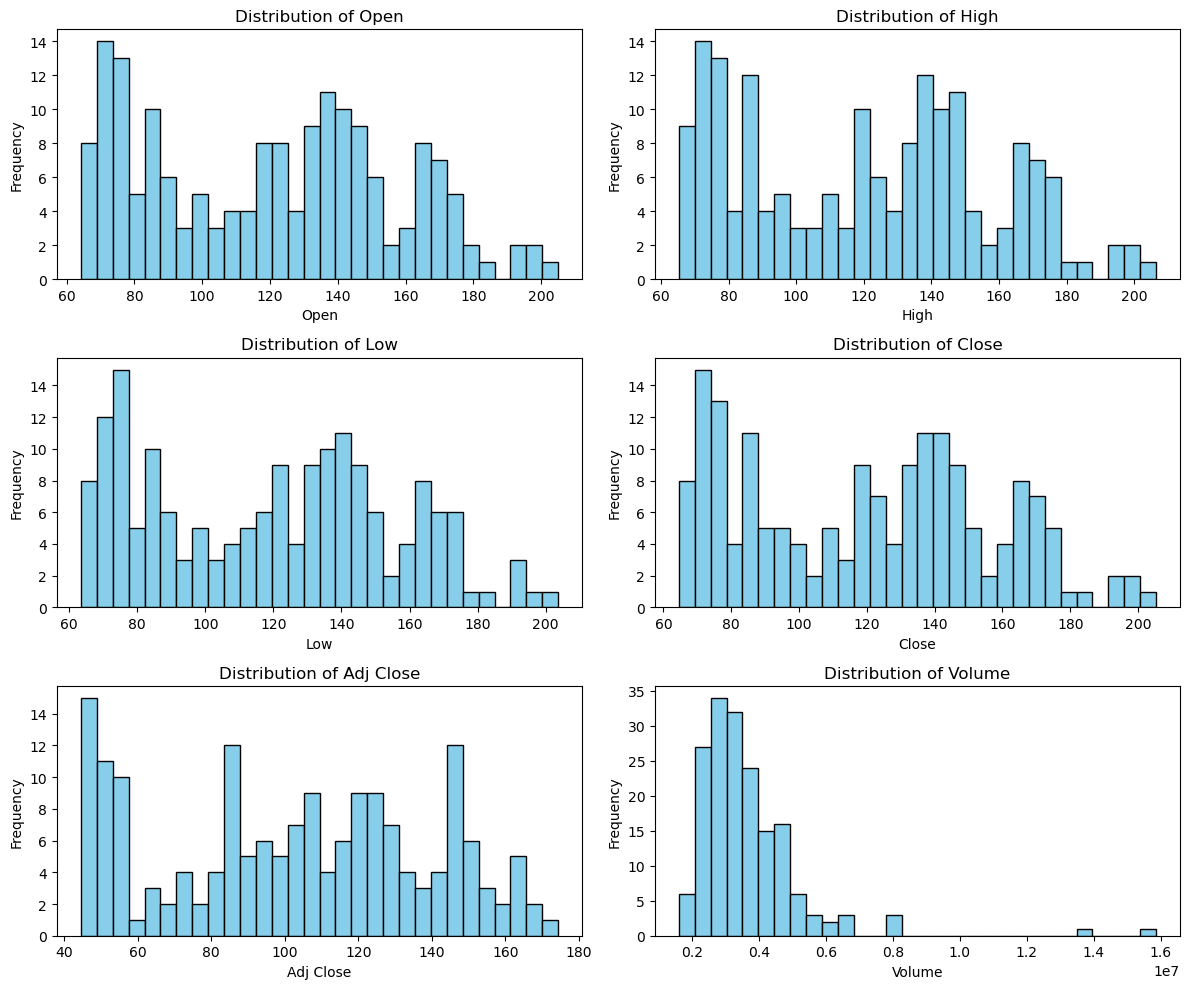

In [97]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
axes = axes.flatten()
numerical_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
for i, column in enumerate(numerical_columns):
    ax = axes[i]
    ax.hist(data[column], bins=30, color='skyblue', edgecolor='black')
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [98]:
numerical_columns = [target_column]
data_to_normalize = data[numerical_columns]
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data_to_normalize)
normalized_df = pd.DataFrame(normalized_data, columns=numerical_columns)
normalized_df['Date'] = data[date_column]
normalized_df.head()

,Close,Date
0,0.034513,2010-01-01
1,0.016098,2010-01-01
2,0.027389,2010-01-01
3,0.048392,2010-01-01
4,0.037251,2010-01-01


# Stationary Check

pValue of adfuller test is : 0.47893510205114037


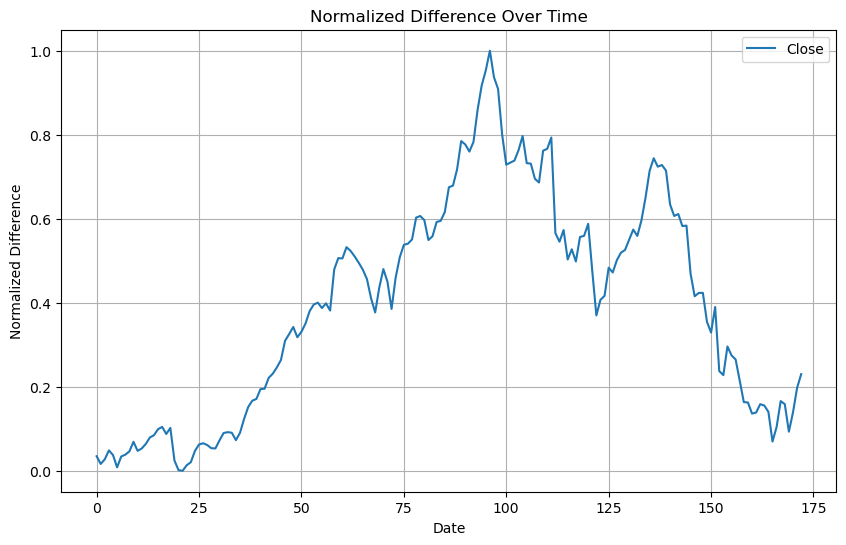

In [100]:
from statsmodels.tsa.stattools import adfuller
adftest=adfuller(normalized_df[target_column])
print('pValue of adfuller test is :',adftest[1])
plt.figure(figsize=(10, 6))
plt.plot(normalized_df.index, normalized_df[target_column], label=target_column)

plt.xlabel('Date')
plt.ylabel('Normalized Difference')
plt.title('Normalized Difference Over Time')
plt.legend()
plt.grid(True)
plt.show()

### Differencing

pValue of adfuller test is : 9.757718144580703e-21


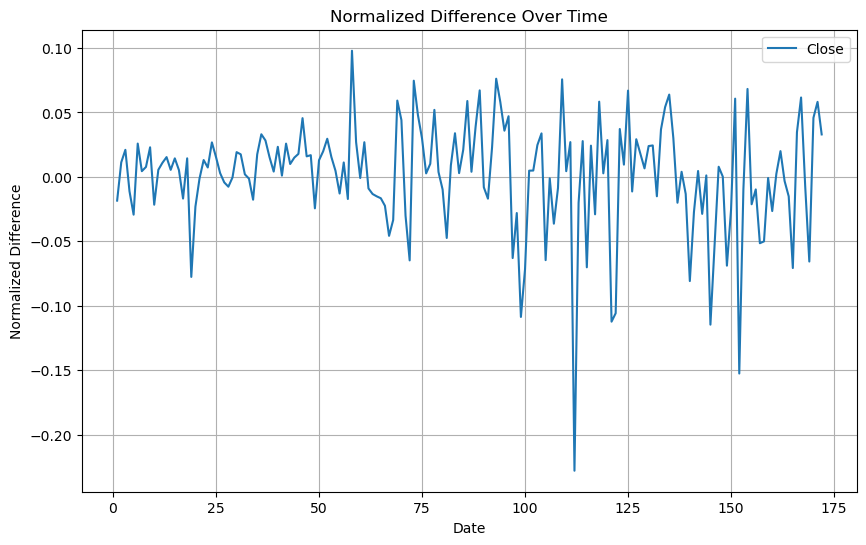

,Close,Date
1,-0.018414,2010-01-01
2,0.011291,2010-01-01
3,0.021003,2010-01-01
4,-0.011141,2010-01-01
5,-0.029287,2010-01-01
...,...,...
168,-0.007185,2024-01-01
169,-0.065658,2024-01-01
170,0.045852,2024-01-01
171,0.058216,2024-01-01


In [101]:
normalized_difference=normalized_df.copy()
for column in numerical_columns:
    normalized_difference[f'{column}'] = normalized_difference[column].diff()
normalized_difference.dropna(inplace=True)
adftest=adfuller(normalized_difference[target_column])
print('pValue of adfuller test is :',adftest[1])
plt.figure(figsize=(10, 6))
plt.plot(normalized_difference.index, normalized_difference[target_column], label=target_column)

plt.xlabel('Date')
plt.ylabel('Normalized Difference')
plt.title('Normalized Difference Over Time')
plt.legend()
plt.grid(True)
plt.show()
normalized_difference

### Logarithim

pValue of adfuller test is : 0.21640878112798612


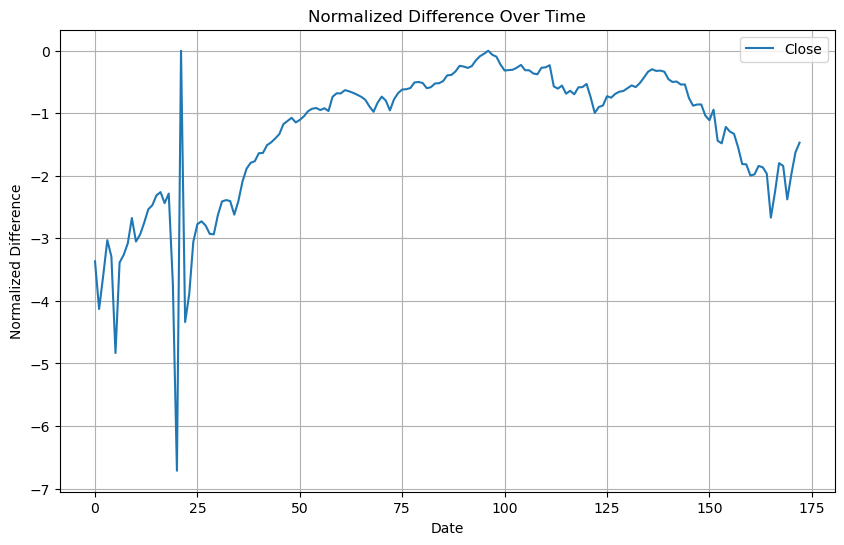

,Close,Date
0,-3.366432,2010-01-01
1,-4.129036,2010-01-01
2,-3.597615,2010-01-01
3,-3.028422,2010-01-01
4,-3.290066,2010-01-01
...,...,...
168,-1.841578,2024-01-01
169,-2.376133,2024-01-01
170,-1.974998,2024-01-01
171,-1.624666,2024-01-01


In [14]:
normalized_log=normalized_df
for column in numerical_columns:
    normalized_log[f'{column}'] = normalized_log[column].apply(lambda x: np.log(x) if x != 0 else 0)
adftest=adfuller(normalized_log[target_column])
print('pValue of adfuller test is :',adftest[1]) 
normalized_log.dropna(inplace=True)
plt.figure(figsize=(10, 6))
plt.plot(normalized_log.index, normalized_log[target_column], label=target_column)

plt.xlabel('Date')
plt.ylabel('Normalized Difference')
plt.title('Normalized Difference Over Time')
plt.legend()
plt.grid(True)
plt.show()
normalized_log

### Breakdown for Stationary Data
Upon testing both difference and logarithmic method i have choosen Loagrithem method because the p value is less then 0.05

In [103]:
# normalized_df=normalized_log
normalized_df=normalized_difference
adftest=adfuller(normalized_df[target_column])
print('pValue of adfuller test is :',adftest[1]) 

pValue of adfuller test is : 9.757718144580703e-21


In [104]:
import pickle
from joblib import dump

## Arima Model

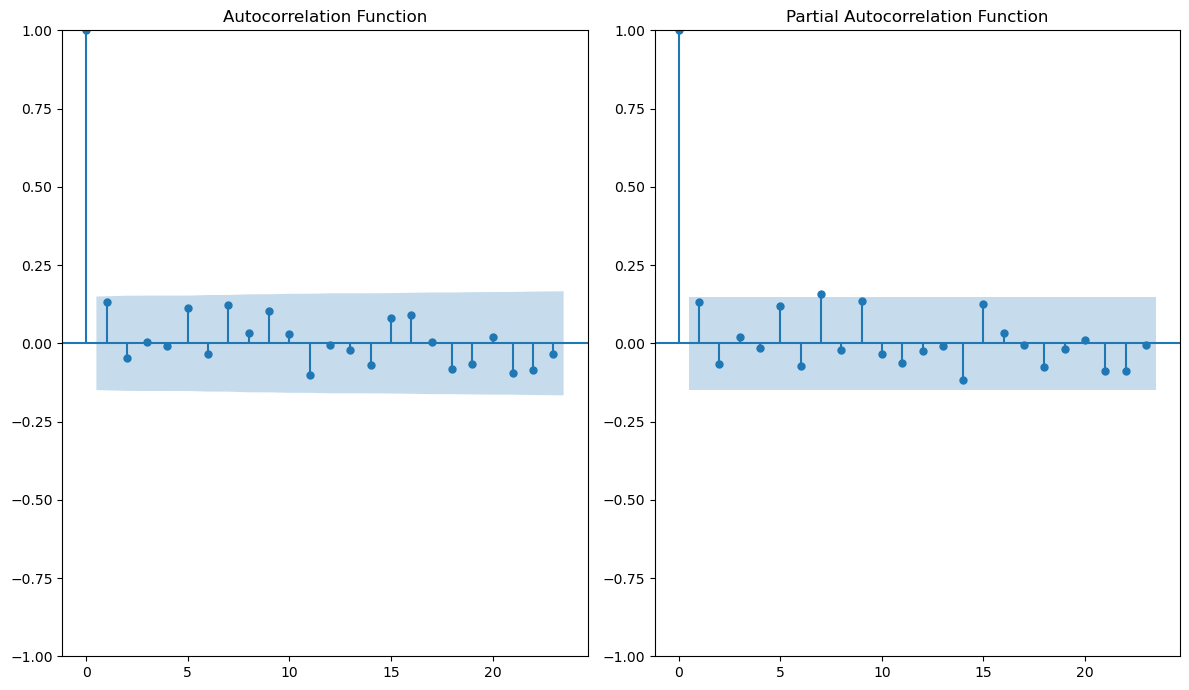

In [105]:
        y = normalized_df[target_column]
        lag_acf = acf(y, nlags=25)
        lag_pacf = pacf(y, nlags=25, method='ols')
        plt.figure(figsize=(12, 7))
        plt.subplot(121)
        plot_acf(y, ax=plt.gca())
        plt.title('Autocorrelation Function')
        plt.subplot(122)
        plot_pacf(y, ax=plt.gca())
        plt.title('Partial Autocorrelation Function')
        plt.tight_layout()
        plt.show()


In [106]:
dummy=normalized_df.copy()
dummy['Date'] = pd.to_datetime(dummy['Date'])
dummy.set_index('Date', inplace=True)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(dummy[target_column], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print("Adfuller Output")
dfoutput

Results of Dickey-Fuller Test:
Adfuller Output


Test Statistic                -1.135550e+01
p-value                        9.757718e-21
#Lags Used                     0.000000e+00
Number of Observations Used    1.710000e+02
dtype: float64

## Evaluation

In [107]:
def evaluation(predictions, y_test):
    mse = mean_squared_error(y_test, predictions)
    r_squared = r2_score(y_test, predictions)
    rmse_arima = np.sqrt(mean_squared_error(y_test, predictions))
    mae_arima = mean_absolute_error(y_test, predictions)
    def mean_absolute_percentage_error(y_true, y_pred): 
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mape_arima = mean_absolute_percentage_error(y_test, predictions)
    return mse, r_squared, rmse_arima, mae_arima, mape_arima

## Splitting

In [299]:
X = normalized_df.drop(columns=['Date'])
y = normalized_df['Close']
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
indexes=y_test.index
yTrain=y_test.values
trainIndexes=

# Arima 

In [300]:
order = (22, 1, 21)  
model = ARIMA(y_train, order=order)
fitted_model = model.fit()
arima_predictions_testing = fitted_model.forecast(steps=len(X_test))
mse_arima, r_squared_arima, rmse_arima, mae_arima, mape_arima = evaluation(arima_predictions_testing, y_test)
print("ARIMA Performance Metrics (Testing Set):")
print("mse:" , mse_arima)
print("R-squared:", r_squared_arima)
print("RMSE:", rmse_arima)
print("MAE:", mae_arima)
print("MAPE:", mape_arima)

ARIMA Performance Metrics (Testing Set):
mse: 0.0031513052018111937
R-squared: -0.26869146426418156
RMSE: 0.056136487259279
MAE: 0.043819337431015855
MAPE: 401.870954583962


# Training

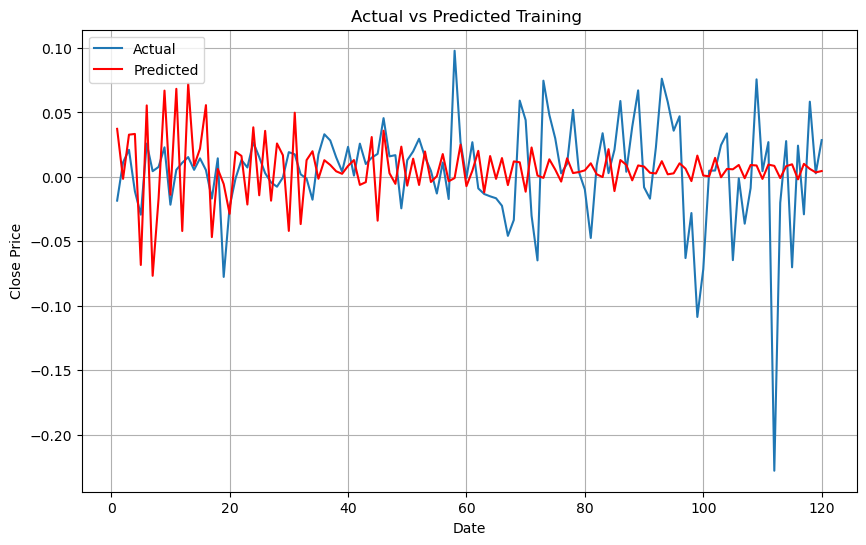

In [178]:
arima_predictions_training = fitted_model.forecast(steps=len(X_train))
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train.values, label='Actual')
plt.plot(y_train.index, arima_predictions_training, color='red', label='Predicted')
plt.title('Actual vs Predicted Training ')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

## Testing GRAPH

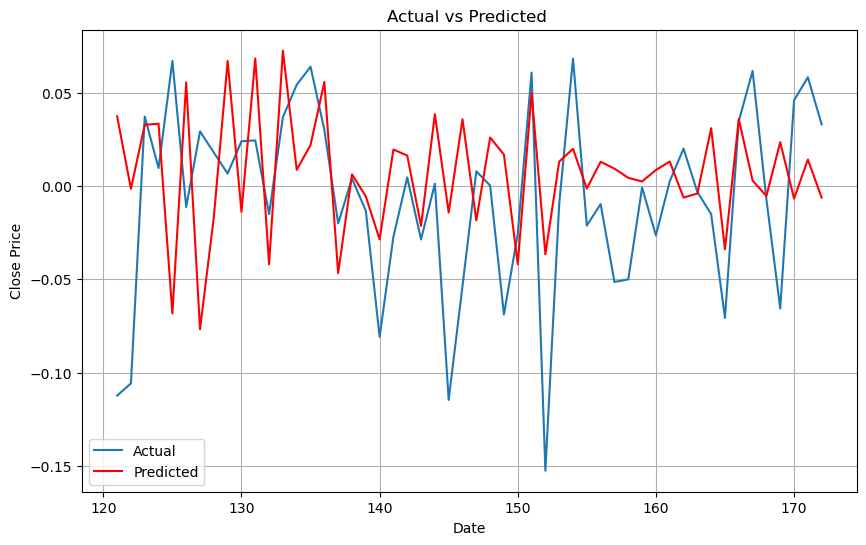

In [185]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, arima_predictions_testing, color='red', label='Predicted')
plt.title('Actual vs Predicted ')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

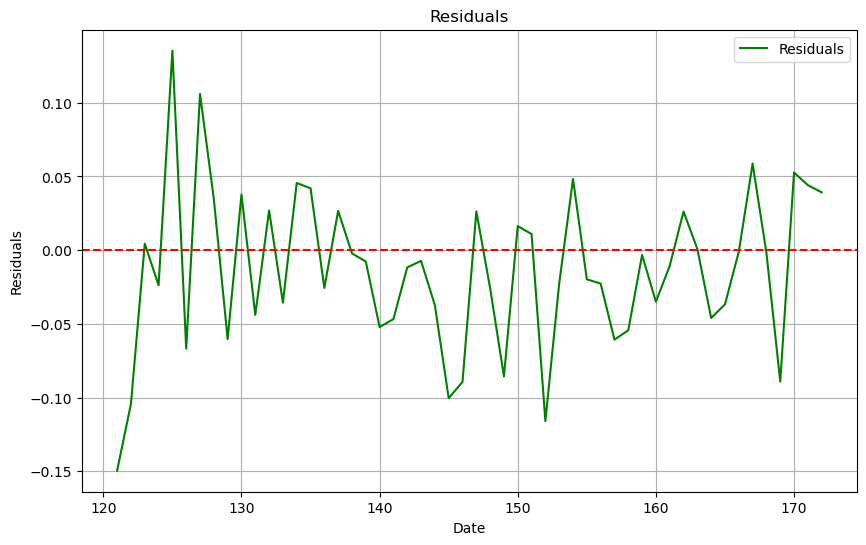

In [180]:
residuals = y_test.values - arima_predictions_testing
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, residuals, color='green', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

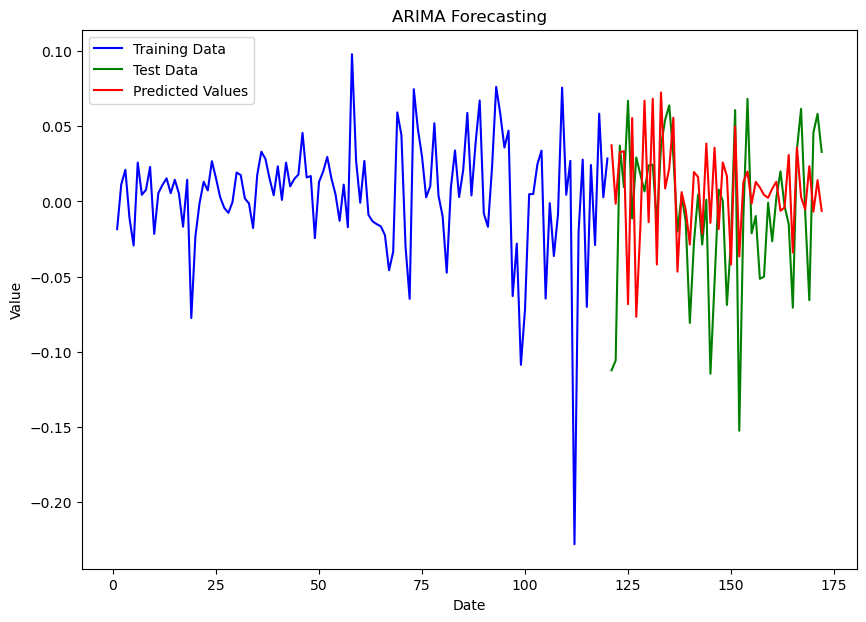

In [181]:
plt.figure(figsize=(10, 7))
plt.plot(y_train.index, y_train.values, label='Training Data', color='blue')
plt.plot(y_test.index, y_test.values, label='Test Data', color='green')

# Plot the predicted values
plt.plot(y_test.index, arima_predictions_testing, label='Predicted Values', color='red')

plt.title('ARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [182]:

# Assuming fitted_model is your trained ARIMA model
# Save the model to a file
with open('models/arima_model.pkl', 'wb') as f:
    pickle.dump(fitted_model, f)


# ANN

In [183]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the architecture of the ANN
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Input layer with 64 neurons and ReLU activation
model.add(Dense(32, activation='relu'))  # Hidden layer with 32 neurons and ReLU activation
model.add(Dense(1, activation='linear'))  # Output layer with 1 neuron for regression task

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2)


Epoch 1/25
3/3 [==============================] - 3s 246ms/step - loss: 5.9122e-04 - val_loss: 0.0031
Epoch 2/25
3/3 [==============================] - 0s 42ms/step - loss: 2.9444e-04 - val_loss: 0.0025
Epoch 3/25
3/3 [==============================] - 0s 39ms/step - loss: 1.4707e-04 - val_loss: 0.0020
Epoch 4/25
3/3 [==============================] - 0s 38ms/step - loss: 8.5755e-05 - val_loss: 0.0016
Epoch 5/25
3/3 [==============================] - 0s 40ms/step - loss: 4.4633e-05 - val_loss: 0.0013
Epoch 6/25
3/3 [==============================] - 0s 43ms/step - loss: 2.4528e-05 - val_loss: 0.0011
Epoch 7/25
3/3 [==============================] - 0s 42ms/step - loss: 1.6799e-05 - val_loss: 9.5336e-04
Epoch 8/25
3/3 [==============================] - 0s 42ms/step - loss: 1.8176e-05 - val_loss: 8.6545e-04
Epoch 9/25
3/3 [==============================] - 0s 37ms/step - loss: 1.6688e-05 - val_loss: 7.7715e-04
Epoch 10/25
3/3 [==============================] - 0s 40ms/step - loss: 1.2506

2/2 [==============================] - 0s 6ms/step


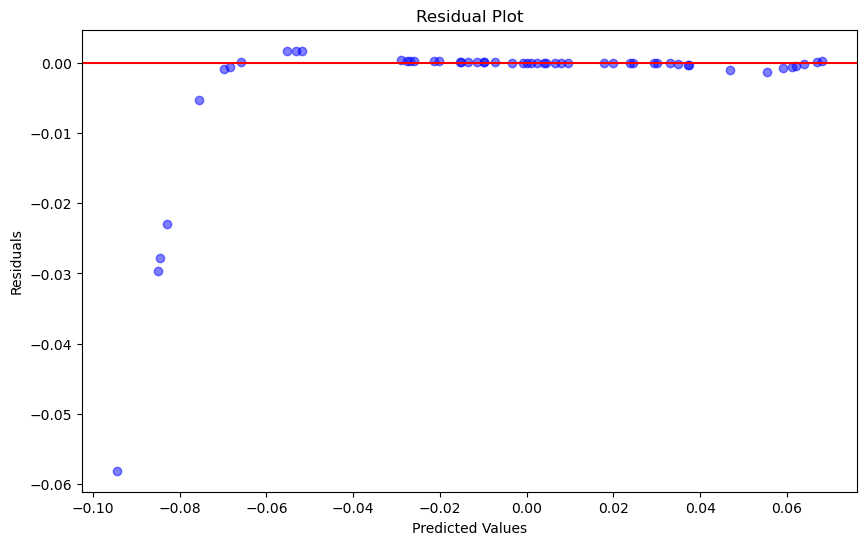

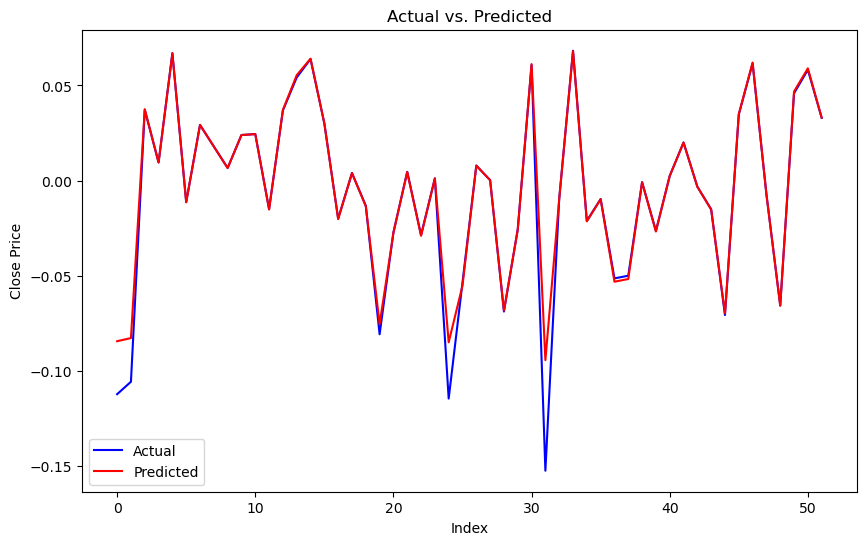

In [186]:
import matplotlib.pyplot as plt

# Predictions
ann_prediction_testing = model.predict(X_test).flatten()

# Residuals
residuals = y_test - ann_prediction_testing

# Residual Plot
plt.figure(figsize=(10, 6))
plt.scatter(ann_prediction_testing, residuals, color='blue', alpha=0.5)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# Actual vs. Predicted Plot
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(ann_prediction_testing, label='Predicted', color='red')
plt.title('Actual vs. Predicted')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()


2/2 [==============================] - 0s 7ms/step


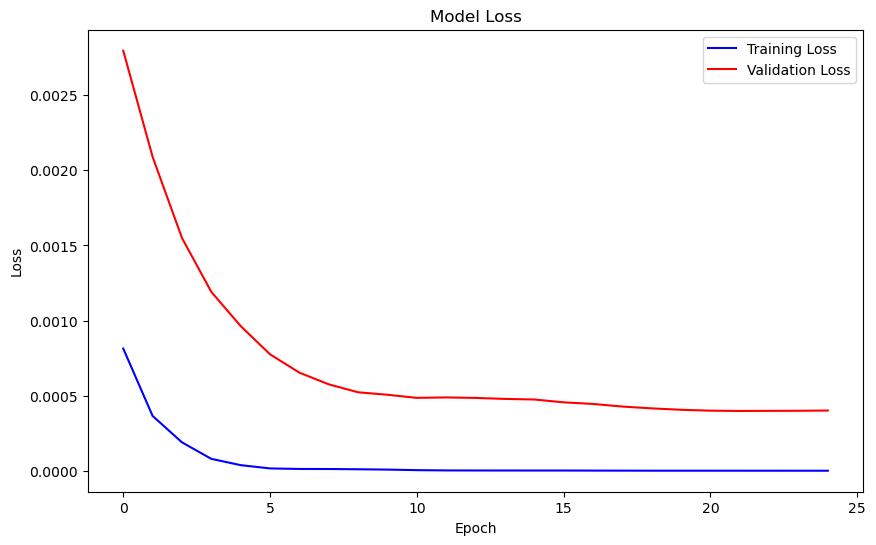

In [119]:
import matplotlib.pyplot as plt

# Get predictions
predictions = model.predict(X_test)


# Plot loss curve during training
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [120]:
y_pred = model.predict(X_test)

# Reshape y_pred if necessary
ann_prediction_testing = y_pred.flatten()

# Evaluate the model using the evaluation function
mse_ann, r_squared_ann, rmse_ann, mae_ann, mape_ann = evaluation(ann_prediction_testing, y_test)

print("Mean Squared Error (MSE):", mse_ann)
print("R-squared (R²):", r_squared_ann)
print("Root Mean Squared Error (RMSE):", rmse_ann)
print("Mean Absolute Error (MAE):", mae_ann)
print("Mean Absolute Percentage Error (MAPE):", mape_ann)



2/2 [==============================] - 0s 5ms/step
Mean Squared Error (MSE): 6.443905503792387e-05
R-squared (R²): 0.9740573274067911
Root Mean Squared Error (RMSE): 0.008027394037788594
Mean Absolute Error (MAE): 0.002257438878584037
Mean Absolute Percentage Error (MAPE): 2.660462630139646


In [121]:
# Save the model to a file
model.save('models/ann_model.h5')

## ETS

In [188]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=12)
ets_model = model.fit()
ets_prediction_testing = ets_model.forecast(len(y_test))

In [189]:
# Evaluate the model
mse_ets, r_squared_ets, rmse_ets, mae_ets, mape_ets = evaluation(ets_prediction_testing, y_test)

print("Mean Squared Error (MSE):", mse_ets)
print("R-squared (R²):", r_squared_ets)
print("Root Mean Squared Error (RMSE):", rmse_ets)
print("Mean Absolute Error (MAE):", mae_ets)
print("Mean Absolute Percentage Error (MAPE):", mape_ets)


Mean Squared Error (MSE): 0.0028636997063932333
R-squared (R²): -0.15290368309258207
Root Mean Squared Error (RMSE): 0.0535135469427437
Mean Absolute Error (MAE): 0.04106864762025083
Mean Absolute Percentage Error (MAPE): 266.06154275166057


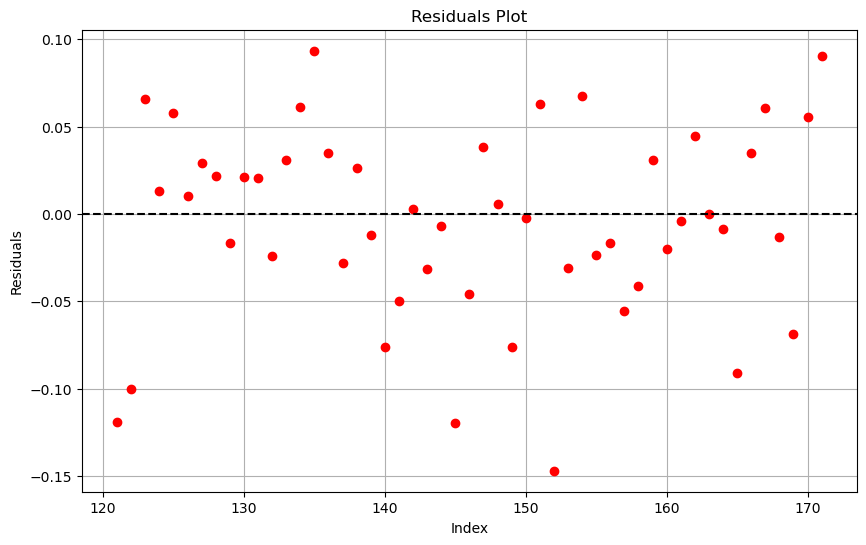

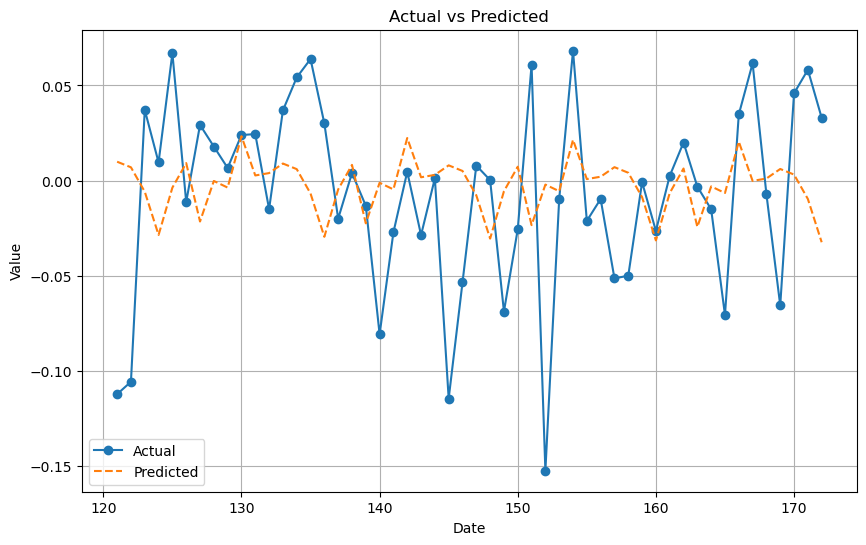

In [190]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_test - ets_prediction_testing

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals, marker='o', linestyle='None', color='r')
plt.axhline(y=0, color='k', linestyle='--')
plt.title('Residuals Plot')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', marker='o')
plt.plot(y_test.index, ets_prediction_testing, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


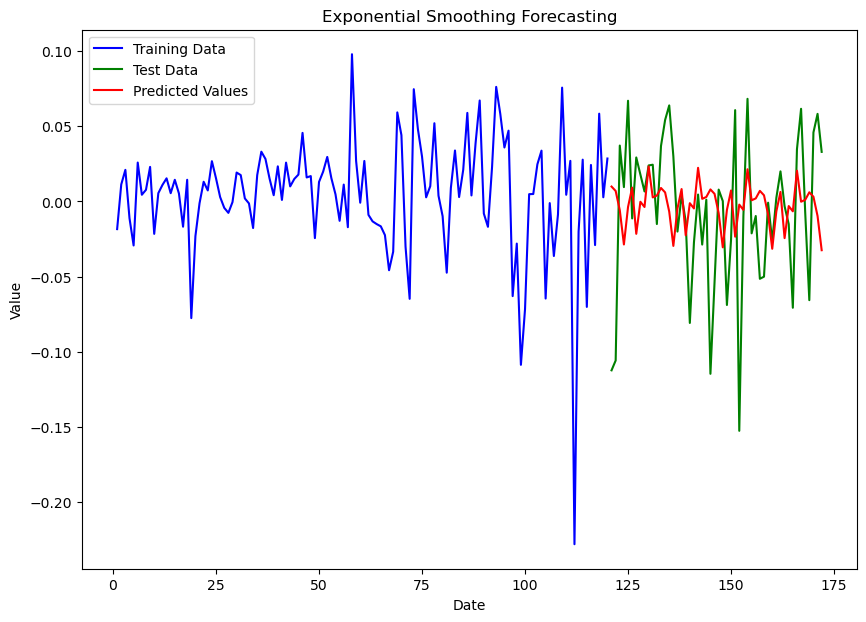

In [125]:
import matplotlib.pyplot as plt

# Plot the training and test data
plt.figure(figsize=(10, 7))
plt.plot(y_train.index, y_train.values, label='Training Data', color='blue')
plt.plot(y_test.index, y_test.values, label='Test Data', color='green')

# Plot the predicted values
plt.plot(y_test.index, ets_prediction_testing, label='Predicted Values', color='red')

plt.title('Exponential Smoothing Forecasting')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


In [126]:
with open('models/ets_model.pkl', 'wb') as f:
    pickle.dump(ets_model, f)

## SVR

In [192]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Initialize SVR model
svr = SVR()

# Define parameter grid for GridSearchCV
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

# Perform GridSearchCV for parameter tuning
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Initialize SVR model with best parameters
best_svr = SVR(kernel=best_params['kernel'], C=best_params['C'], gamma=best_params['gamma'])

# Fit the SVR model on the training data
best_svr.fit(X_train, y_train)

# Make predictions on the test data
svr_prediction_testing = best_svr.predict(X_test)


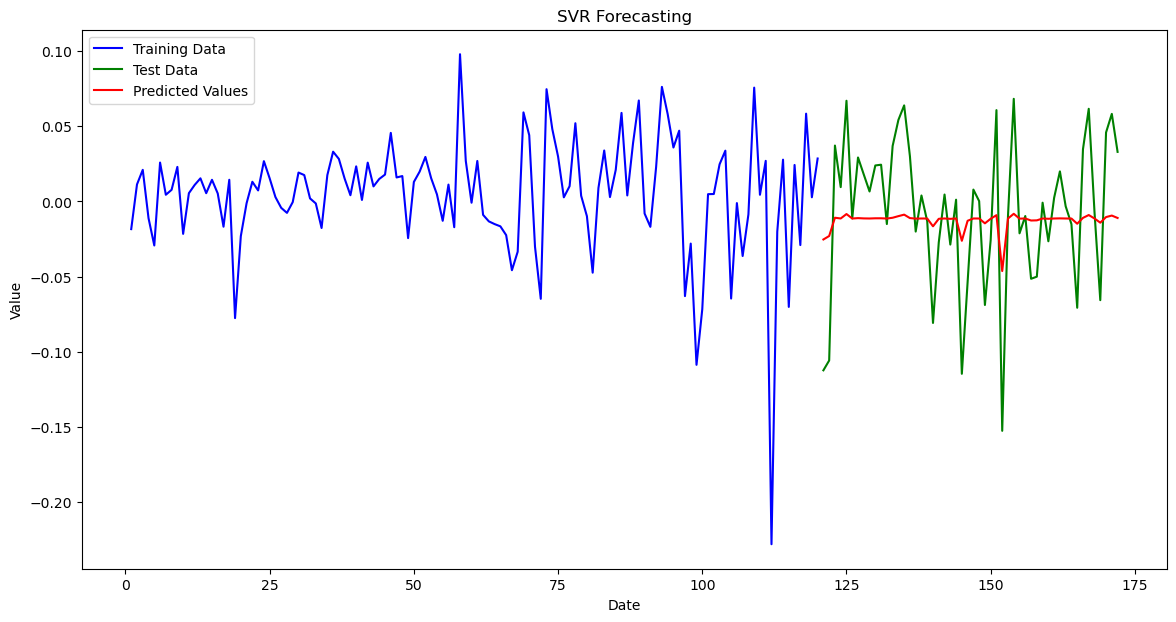

In [193]:
import matplotlib.pyplot as plt

# Plot the training and test data
plt.figure(figsize=(14, 7))
plt.plot(y_train.index, y_train.values, label='Training Data', color='blue')
plt.plot(y_test.index, y_test.values, label='Test Data', color='green')

# Plot the predicted values
plt.plot(y_test.index, svr_prediction_testing, label='Predicted Values', color='red')

plt.title('SVR Forecasting')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


In [194]:
mse_svr, r_squared_svr, rmse_svr, mae_svr, mape_svr = evaluation(svr_prediction_testing, y_test)

# Print evaluation metrics
print("SVR Model Evaluation:")
print("Mean Squared Error (MSE):", mse_svr)
print("R-squared Score:", r_squared_svr)
print("Root Mean Squared Error (RMSE):", rmse_svr)
print("Mean Absolute Error (MAE):", mae_svr)
print("Mean Absolute Percentage Error (MAPE):", mape_svr)



SVR Model Evaluation:
Mean Squared Error (MSE): 0.002098982896898935
R-squared Score: 0.154965477986181
Root Mean Squared Error (RMSE): 0.0458146581008626
Mean Absolute Error (MAE): 0.03655453935253364
Mean Absolute Percentage Error (MAPE): 263.3692692768397


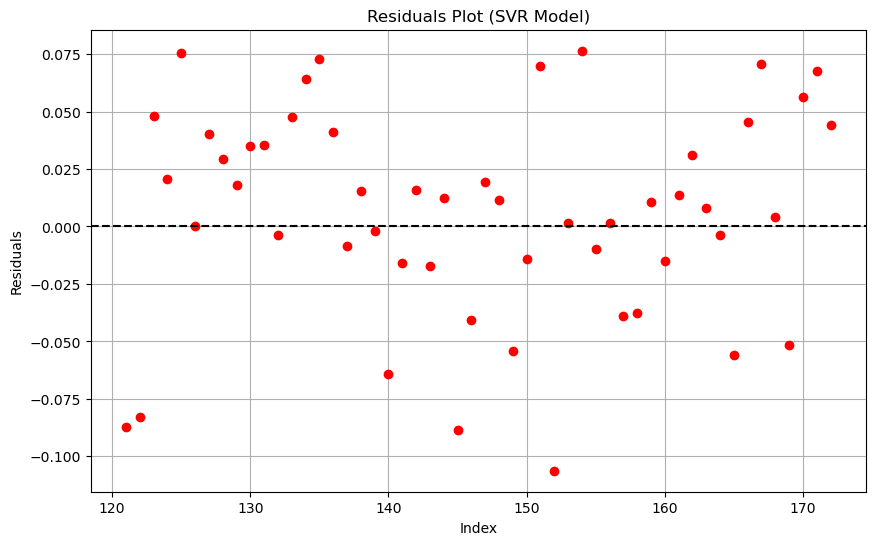

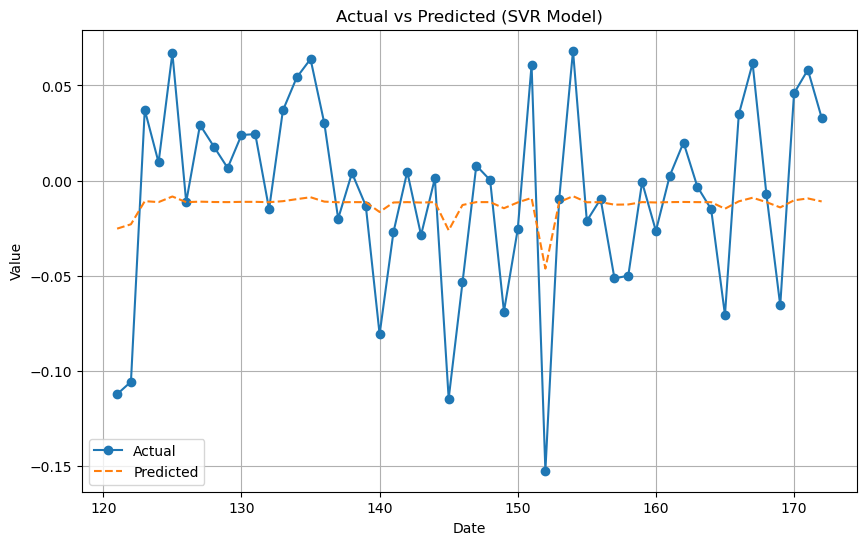

In [130]:
residuals_svr = y_test - svr_prediction_testing

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals_svr, marker='o', linestyle='None', color='r')
plt.axhline(y=0, color='k', linestyle='--')
plt.title('Residuals Plot (SVR Model)')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', marker='o')
plt.plot(y_test.index, svr_prediction_testing, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted (SVR Model)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [131]:
dump(best_svr, 'models/svr_model.joblib')

['models/svr_model.joblib']

## Hybrid Models Integration:

In [271]:
X = normalized_df.drop(columns=['Date'])
y = normalized_df['Close']
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [205]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Train ARIMA model
arima_model = ARIMA(y_train, order=(22,1,21))  # Example order, you may need to tune this
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=len(X_test)).values

# Calculate residuals
arima_residuals = y_train - arima_result.fittedvalues

# Train ANN model
ann_model = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=1000)
ann_model.fit(X_train, arima_residuals)

# Forecast residuals using ANN
ann_forecast = ann_model.predict(X_test)

# Combine ARIMA forecasts with ANN forecasts of residuals
final_forecast = arima_forecast + ann_forecast

In [206]:
final_forecast_Hybrid_Model=final_forecast

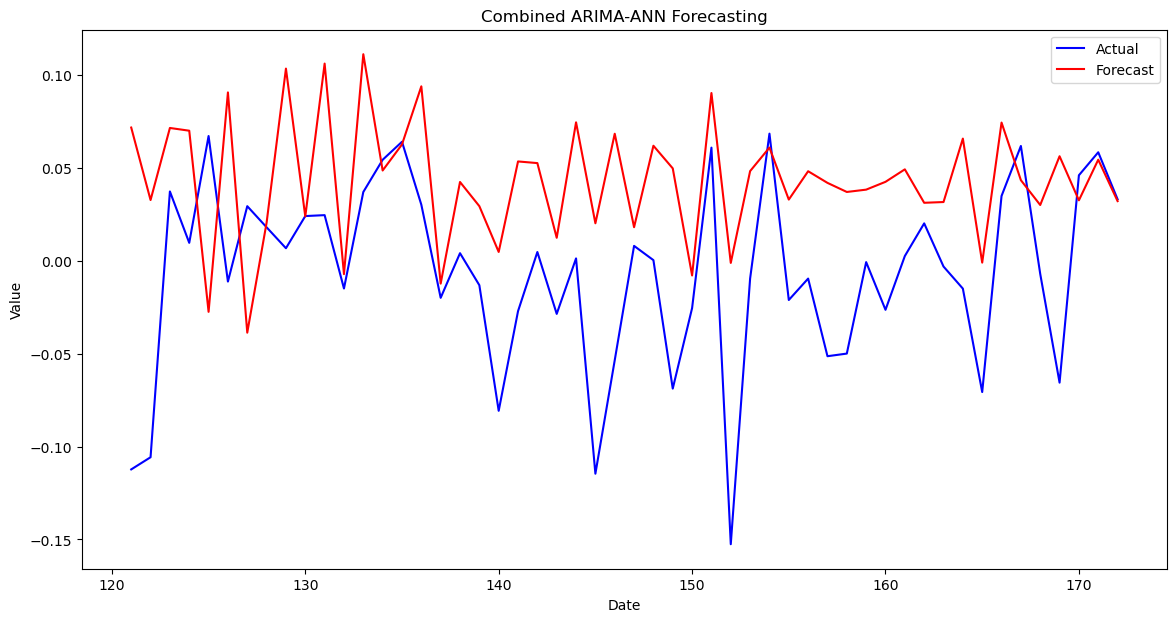

In [134]:
import matplotlib.pyplot as plt

# Plot the actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test.values, label='Actual', color='blue')

# Plot the combined forecasted values
plt.plot(y_test.index, final_forecast, label='Forecast', color='red')

plt.title('Combined ARIMA-ANN Forecasting')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


In [135]:
mse_hybrid, r_squared_hybrid, rmse_arima_hybrid, mae_arima_hybrid, mape_arima_hybrid = evaluation(final_forecast, y_test)

print("Mean Squared Error:", mse_hybrid)
print("R-squared:", r_squared_hybrid)
print("Root Mean Squared Error:", rmse_arima_hybrid)
print("Mean Absolute Error:", mae_arima_hybrid)
print("Mean Absolute Percentage Error:", mape_arima_hybrid)




Mean Squared Error: 0.005266591021162059
R-squared: -1.1202894186441954
Root Mean Squared Error: 0.07257128234475438
Mean Absolute Error: 0.05803318153432813
Mean Absolute Percentage Error: 1054.165659165731


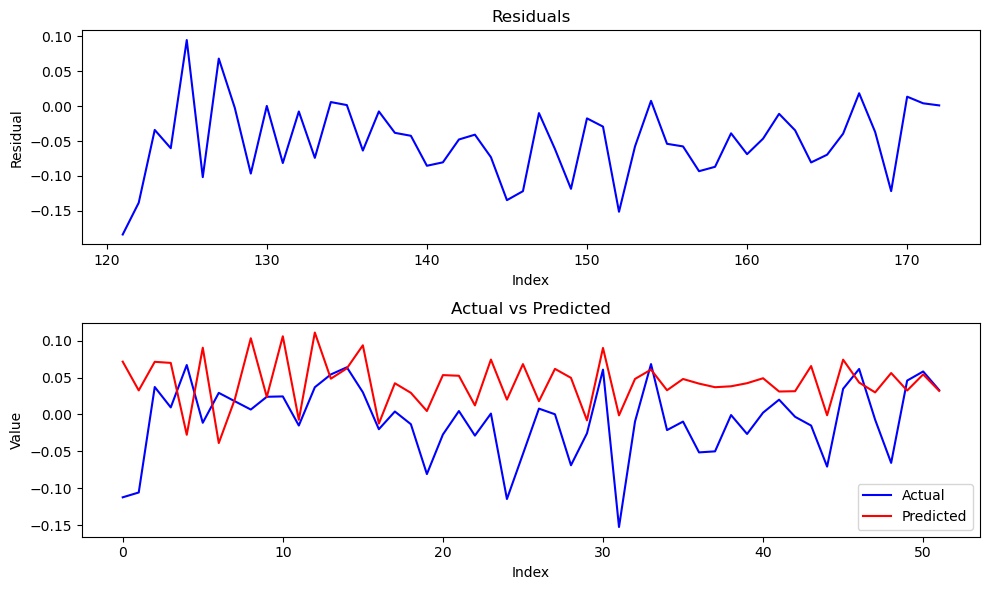

In [136]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_test - final_forecast

# Plot residual distribution
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(residuals, color='blue')
plt.title('Residuals')
plt.xlabel('Index')
plt.ylabel('Residual')

# Plot actual vs predicted
plt.subplot(2, 1, 2)
plt.plot(y_test.values, color='blue', label='Actual')
plt.plot(final_forecast, color='red', label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()


In [207]:
from tensorflow.keras.models import model_from_json

# Save model architecture to JSON file
# model_json = model.to_json()
# with open("models/hybrid_model.json", "w") as json_file:
#     json_file.write(model_json)

# # Save model weights to HDF5 file
# model.save_weights("models/hybrid_model_weights.weights.h5")


## Sarima

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

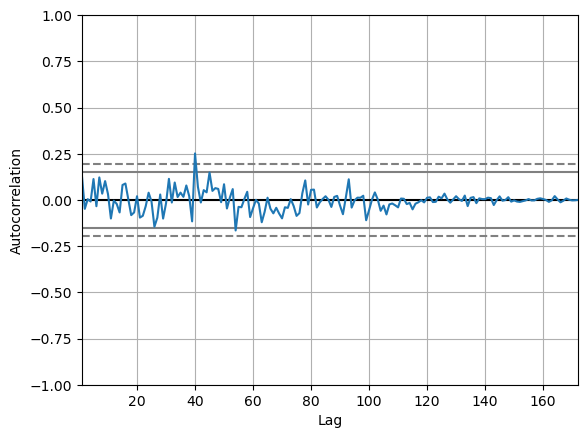

In [208]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(normalized_df['Close'])

<Figure size 640x480 with 0 Axes>

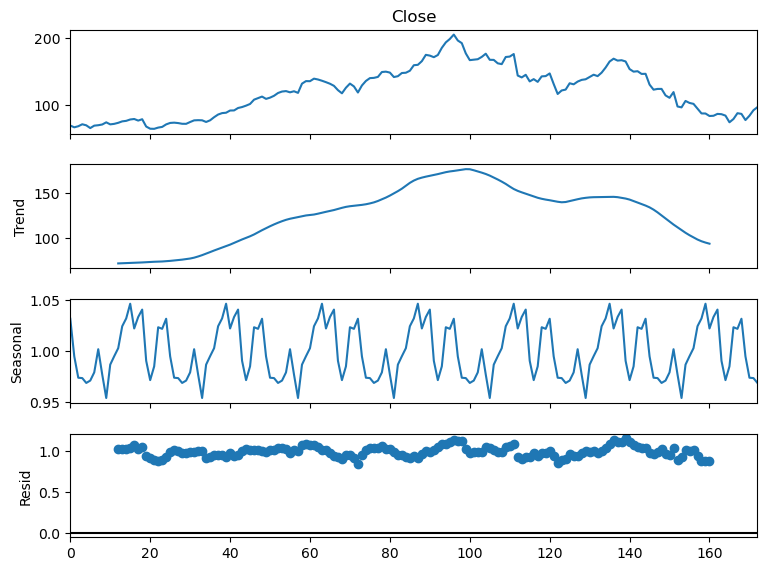

In [209]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data["Close"], model='multiplicative', period=24)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(8, 6)
fig.show()

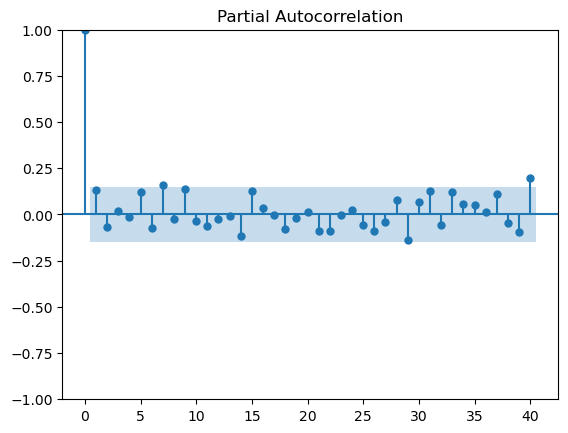

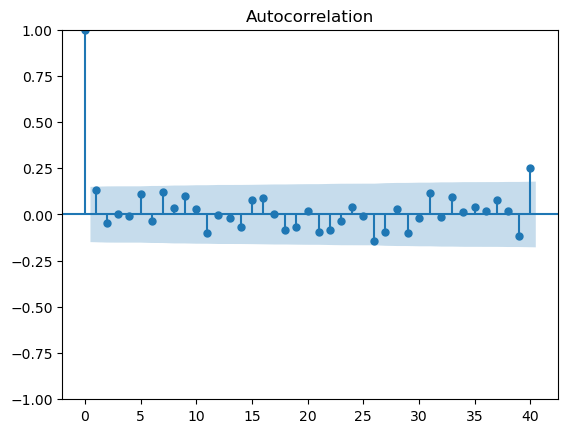

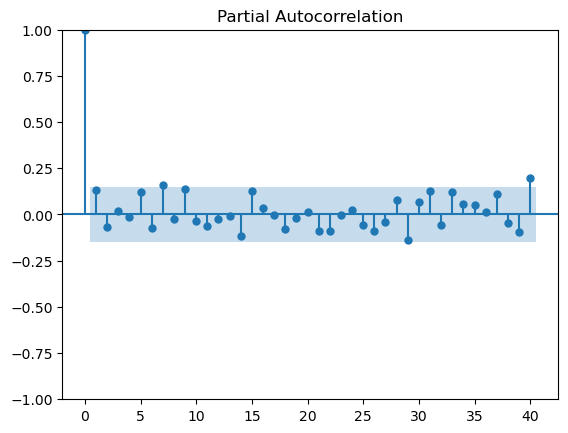

In [210]:
plot_acf(normalized_df['Close'], lags=40)
plot_pacf(normalized_df['Close'], lags=40)

In [211]:
import pmdarima as pmd

model=pmd.auto_arima(normalized_df['Close'],start_p=1,start_q=1,test='adf',m=12,seasonal=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-591.537, Time=1.26 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-589.925, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-589.016, Time=0.58 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-589.433, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-591.806, Time=0.06 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=-587.929, Time=0.14 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-587.928, Time=0.17 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-585.935, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-590.991, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-591.405, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-595.537, Time=0.39 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-593.541, Time=1.10 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-593.540, Time=1.30 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=-593.676, Time=0.74 sec
 ARIMA(1,0,2)(0,0,0

In [212]:
sarima_model = SARIMAX(y_train, order=(21, 1, 1), seasonal_order=(0, 0, 0, 12))
fitted_sarima_model = sarima_model.fit()

In [213]:
sarima_predictions = fitted_sarima_model.forecast(steps=len(X_test))
mse_sarima, r_squared_sarima, rmse_sarima, mae_sarima, mape_sarima = evaluation(sarima_predictions, y_test)
print("SARIMA Performance Metrics (Testing Set):")
print("mse:" , mse_sarima)
print("R-squared:", r_squared_sarima)
print("RMSE:", rmse_sarima)
print("MAE:", mae_sarima)
print("MAPE:", mape_sarima)



SARIMA Performance Metrics (Testing Set):
mse: 0.002577160670728163
R-squared: -0.0375452504920748
RMSE: 0.05076574308259619
MAE: 0.03836787820410093
MAPE: 373.0375168999606


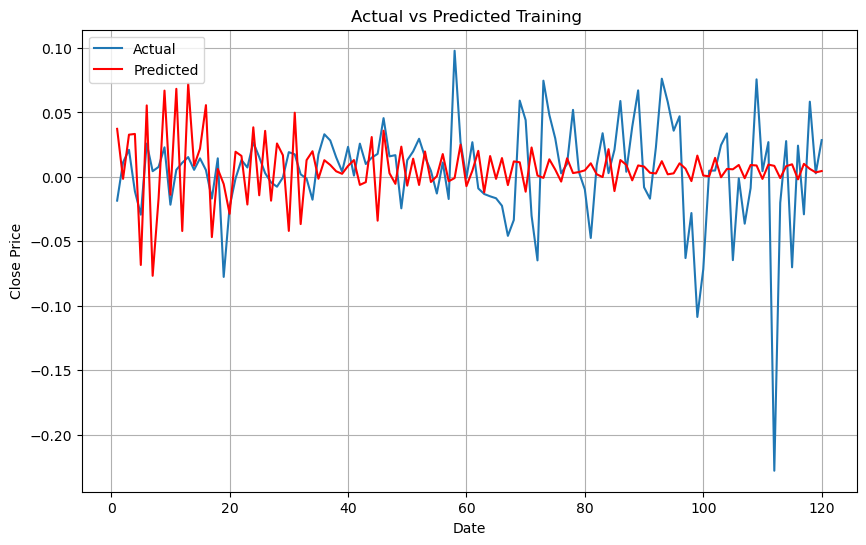

In [218]:
sarima_predictions_training = fitted_model.forecast(steps=len(X_train))
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train.values, label='Actual')
plt.plot(y_train.index, sarima_predictions_training, color='red', label='Predicted')
plt.title('Actual vs Predicted Training ')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

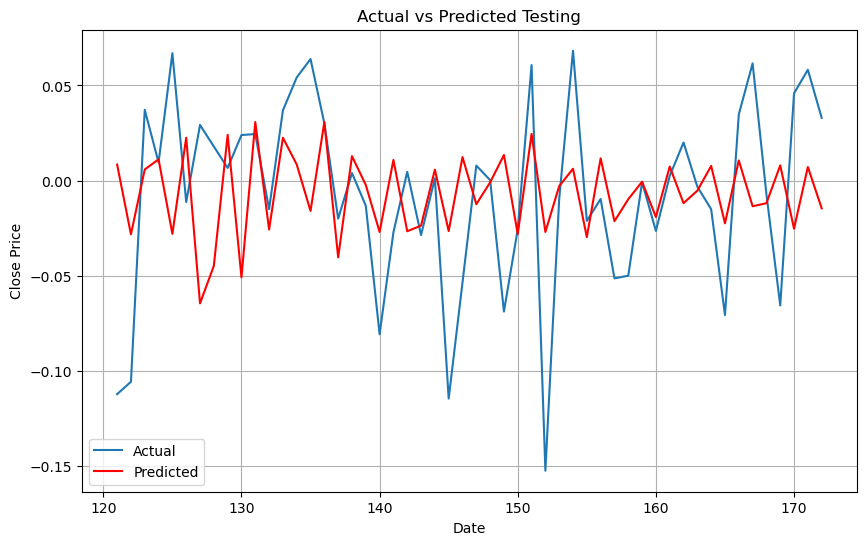

In [219]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, sarima_predictions, color='red', label='Predicted')
plt.title('Actual vs Predicted Testing')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [220]:
with open('models/sarima_model.pkl', 'wb') as f:
    pickle.dump(fitted_sarima_model, f)

## Prophet

In [254]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model):
    # Perform cross-validation
    df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')
    
    # Calculate metrics
    mae = mean_absolute_error(df_cv['y'], df_cv['yhat'])
    mse = mean_squared_error(df_cv['y'], df_cv['yhat'])
    rmse = np.sqrt(mse)
    r_squared = r2_score(df_cv['y'], df_cv['yhat'])
    
    # Calculate MAPE
    def mean_absolute_percentage_error(y_true, y_pred): 
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mape = mean_absolute_percentage_error(df_cv['y'], df_cv['yhat'])
    
    return mae, mse, rmse, r_squared, mape, df_cv

prophet_df = normalized_df.rename(columns={"Close": "y", "Date": "ds"})
model = Prophet(seasonality_mode='additive', changepoint_prior_scale=0.5) 
model.fit(prophet_df)  



18:08:17 - cmdstanpy - INFO - Chain [1] start processing
18:08:17 - cmdstanpy - INFO - Chain [1] done processing


In [255]:
mse_pro, r_squared_pro, rmse_pro, mae_pro,  mape_pro ,df_cv= evaluate_model(model)
print("MSE:", mse_pro)
print("R square):", r_squared_pro)
print("RMSE:", rmse_pro)
print("MAE:", mae_pro)
print("MAPE:", mape_pro)

  0%|          | 0/23 [00:00<?, ?it/s]

18:08:19 - cmdstanpy - INFO - Chain [1] start processing
18:08:20 - cmdstanpy - INFO - Chain [1] done processing
18:08:20 - cmdstanpy - INFO - Chain [1] start processing
18:08:20 - cmdstanpy - INFO - Chain [1] done processing
18:08:20 - cmdstanpy - INFO - Chain [1] start processing
18:08:21 - cmdstanpy - INFO - Chain [1] done processing
18:08:21 - cmdstanpy - INFO - Chain [1] start processing
18:08:21 - cmdstanpy - INFO - Chain [1] done processing
18:08:22 - cmdstanpy - INFO - Chain [1] start processing
18:08:22 - cmdstanpy - INFO - Chain [1] done processing
18:08:23 - cmdstanpy - INFO - Chain [1] start processing
18:08:23 - cmdstanpy - INFO - Chain [1] done processing
18:08:24 - cmdstanpy - INFO - Chain [1] start processing
18:08:24 - cmdstanpy - INFO - Chain [1] done processing
18:08:24 - cmdstanpy - INFO - Chain [1] start processing
18:08:25 - cmdstanpy - INFO - Chain [1] done processing
18:08:25 - cmdstanpy - INFO - Chain [1] start processing
18:08:26 - cmdstanpy - INFO - Chain [1]

MSE: 0.03800626352072861
R square): 0.0024753309230488236
RMSE: 0.049752697645945025
MAE: -0.1116221656068257
MAPE: 240.74686219129705


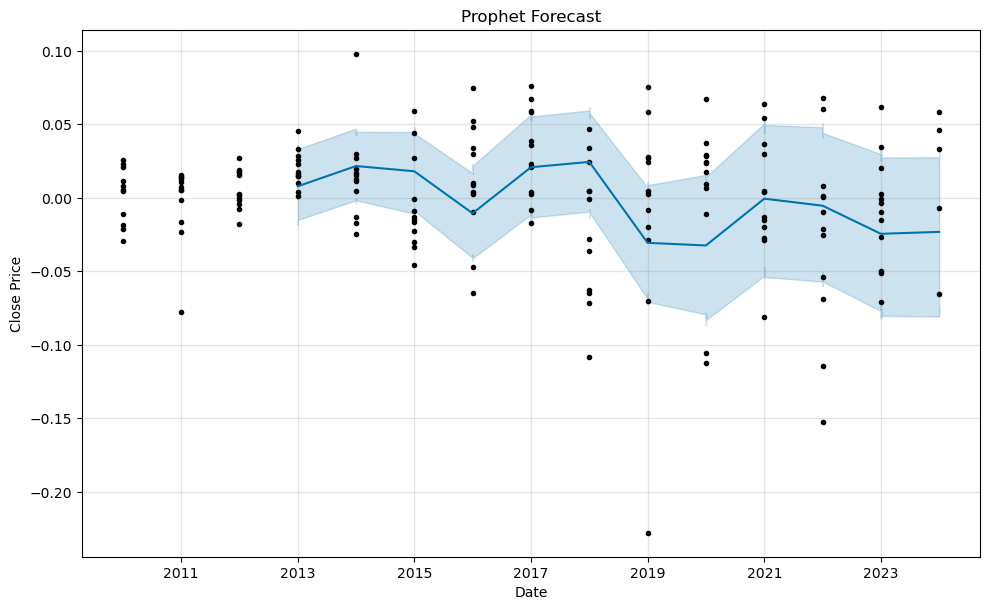

In [256]:
# Plot the forecast
fig = model.plot(df_cv)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Prophet Forecast')
plt.show()

In [261]:
len(df_cv['ds'][:50])
df_cv['ds'][:52]

0    2013-01-01
1    2013-01-01
2    2013-01-01
3    2013-01-01
4    2013-01-01
5    2013-01-01
6    2013-01-01
7    2013-01-01
8    2013-01-01
9    2013-01-01
10   2013-01-01
11   2013-01-01
12   2013-01-01
13   2013-01-01
14   2013-01-01
15   2013-01-01
16   2013-01-01
17   2013-01-01
18   2013-01-01
19   2013-01-01
20   2013-01-01
21   2013-01-01
22   2013-01-01
23   2013-01-01
24   2014-01-01
25   2014-01-01
26   2014-01-01
27   2014-01-01
28   2014-01-01
29   2014-01-01
30   2014-01-01
31   2014-01-01
32   2014-01-01
33   2014-01-01
34   2014-01-01
35   2014-01-01
36   2014-01-01
37   2014-01-01
38   2014-01-01
39   2014-01-01
40   2014-01-01
41   2014-01-01
42   2014-01-01
43   2014-01-01
44   2014-01-01
45   2014-01-01
46   2014-01-01
47   2014-01-01
48   2015-01-01
49   2015-01-01
50   2015-01-01
51   2015-01-01
Name: ds, dtype: datetime64[ns]

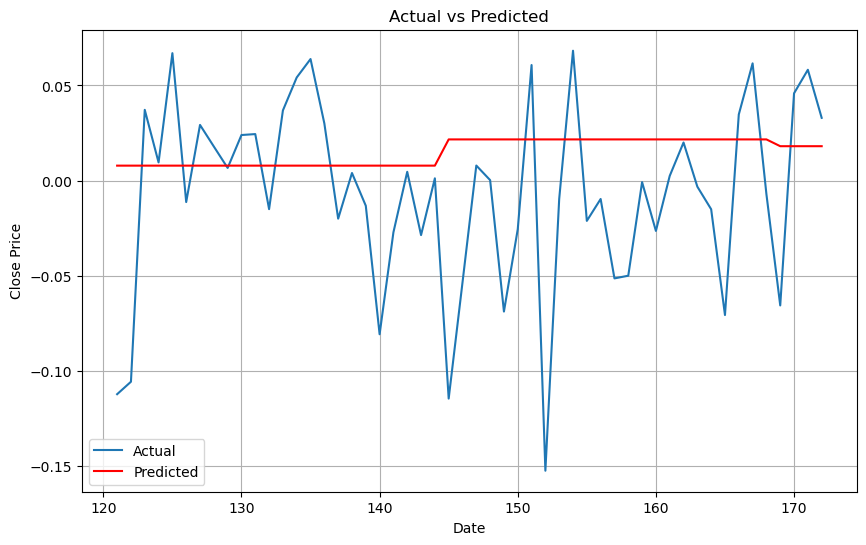

In [264]:

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, df_cv['yhat'][:52], color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()


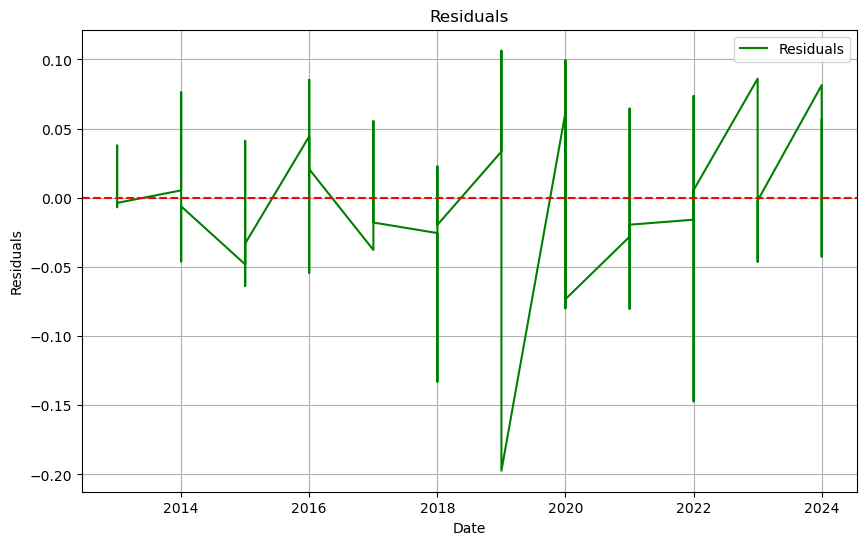

In [227]:

# Calculate residuals
residuals = df_cv['y'] - df_cv['yhat']

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(df_cv['ds'], residuals, color='green', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

In [228]:
with open('models/prophet_model.pkl', 'wb') as f:
    pickle.dump(model, f)

## LSTM

In [229]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
# Assuming your X_train and X_test are pandas DataFrames
X_train = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# You can add more LSTM layers if needed
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=27, batch_size=32)
score = model.evaluate(X_test, y_test)
print('Test loss:', score)

Epoch 1/27
4/4 [==============================] - 14s 11ms/step - loss: 0.0016
Epoch 2/27
4/4 [==============================] - 0s 10ms/step - loss: 0.0015
Epoch 3/27
4/4 [==============================] - 0s 21ms/step - loss: 0.0015
Epoch 4/27
4/4 [==============================] - 0s 9ms/step - loss: 0.0015
Epoch 5/27
4/4 [==============================] - 0s 8ms/step - loss: 0.0014
Epoch 6/27
4/4 [==============================] - 0s 9ms/step - loss: 0.0014
Epoch 7/27
4/4 [==============================] - 0s 9ms/step - loss: 0.0014
Epoch 8/27
4/4 [==============================] - 0s 9ms/step - loss: 0.0013
Epoch 9/27
4/4 [==============================] - 0s 9ms/step - loss: 0.0013
Epoch 10/27
4/4 [==============================] - 0s 9ms/step - loss: 0.0013
Epoch 11/27
4/4 [==============================] - 0s 9ms/step - loss: 0.0012
Epoch 12/27
4/4 [==============================] - 0s 9ms/step - loss: 0.0012
Epoch 13/27
4/4 [==============================] - 0s 9ms/step - loss

2/2 [==============================] - 3s 9ms/step


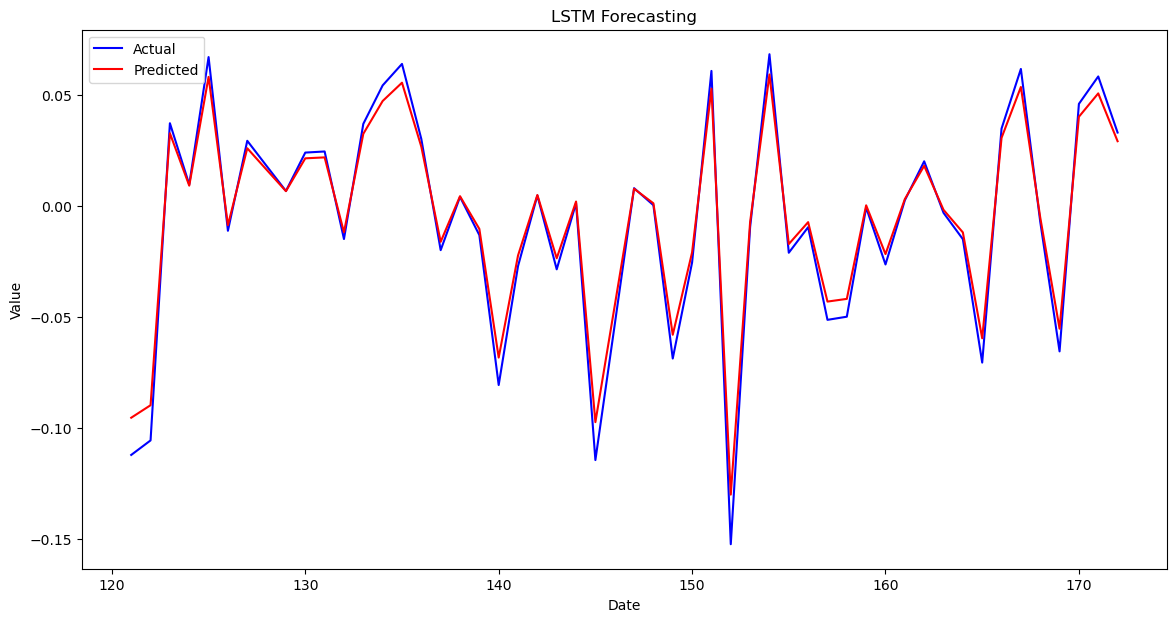

In [230]:
# Make predictions on the test data
lstm_prediction_testing = model.predict(X_test)

# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test.values, label='Actual', color='blue')
plt.plot(y_test.index, lstm_prediction_testing, label='Predicted', color='red')

plt.title('LSTM Forecasting')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

2/2 [==============================] - 0s 9ms/step


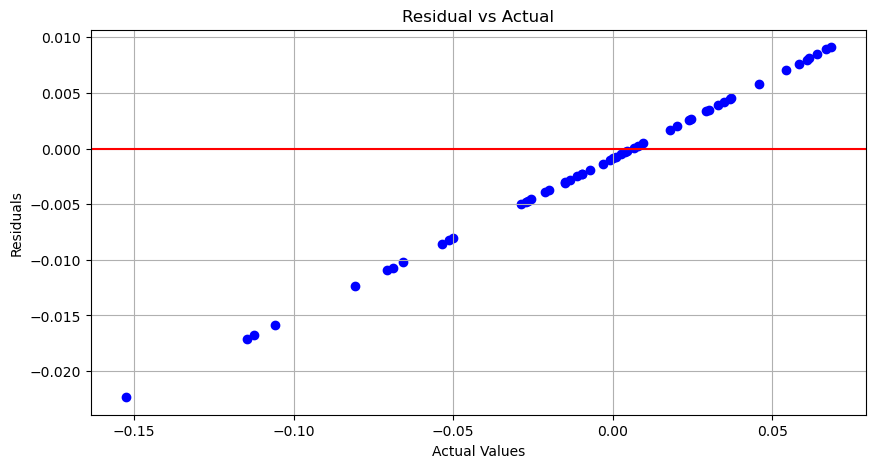

In [231]:
# Make predictions on test data
lstm_prediction_testing = model.predict(X_test)

# Calculate residuals
residuals = y_test - lstm_prediction_testing.flatten()

# Plot residual vs actual
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals, color='blue')
plt.title('Residual vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.grid(True)
plt.show()


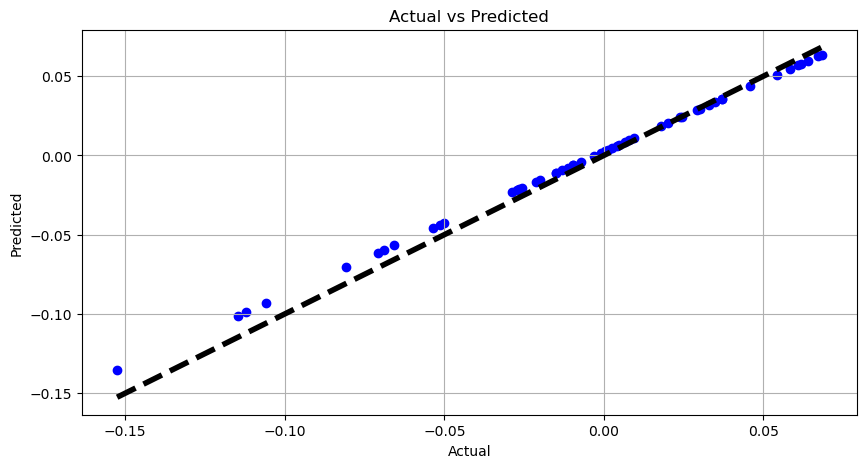

In [157]:
# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.scatter(y_test, lstm_prediction_testing, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)
plt.show()

In [158]:
import numpy as np

lstm_prediction_testing = np.array(lstm_prediction_testing)
y_test = np.array(y_test)

lstm_prediction_testing_flat = lstm_prediction_testing.flatten()
y_test_flat = y_test.flatten()

# Pass the flattened arrays to the evaluation function
mse_lstm, r_squared_lstm, rmse_lstm, mae_lstm, mape_lstm = evaluation(lstm_prediction_testing_flat, y_test_flat)

print("LSTM Model Evaluation:")
print("Mean Squared Error (MSE):", mse_lstm)
print("R-squared Score:", r_squared_lstm)
print("Root Mean Squared Error (RMSE):", rmse_lstm)
print("Mean Absolute Error (MAE):", mae_lstm)
print("Mean Absolute Percentage Error (MAPE):", mape_lstm)


LSTM Model Evaluation:
Mean Squared Error (MSE): 3.401503256385984e-05
R-squared Score: 0.9863058070523812
Root Mean Squared Error (RMSE): 0.005832240784112042
Mean Absolute Error (MAE): 0.00445506676443915
Mean Absolute Percentage Error (MAPE): 49.32802964404645


In [159]:
# Save the LSTM model to a file
model.save('models/lstm_model.h5')

In [160]:
#after running the lstm you will get error of index because lstm faltten the y_test so re run only the starting code where we are splitting the data you will not get any error than.

In [161]:
prophet_predicted_values = df_cv['yhat']


In [297]:
# import sqlite3

# # Connect to the SQLite database
# conn = sqlite3.connect('your_database.db')
# cursor = conn.cursor()

# # Create the testing table if it doesn't exist
# cursor.execute('''CREATE TABLE IF NOT EXISTS testing (
#                     y_train_index INT,
#                     actual_value FLOAT,
#                     arima_prediction FLOAT,
#                     ann_prediction FLOAT,
#                     sarima_prediction FLOAT,
#                     ets_prediction_testing,
#                     svr_prediction_testing,
#                     lstm_prediction_testing,
#                     prophet_predicted_values
#                     );''')

In [298]:
# cursor.execute('''SELECT * FROM testing''')

# # Fetch all rows from the result set
# rows = cursor.fetchall()

# # Print the retrieved data
# for row in rows:
#     print(row)

# # Close the connection
# conn.close()

In [203]:

len(arima_predictions_testing) 

52

In [293]:
indexes
prophet_predictions=df_cv['yhat'][:52]
len(prophet_prediction)
# len(indexes)
len(indexes)==len(prophet_predictions)
prophet_predictions

0     0.007827
1     0.007827
2     0.007827
3     0.007827
4     0.007827
5     0.007827
6     0.007827
7     0.007827
8     0.007827
9     0.007827
10    0.007827
11    0.007827
12    0.007827
13    0.007827
14    0.007827
15    0.007827
16    0.007827
17    0.007827
18    0.007827
19    0.007827
20    0.007827
21    0.007827
22    0.007827
23    0.007827
24    0.021611
25    0.021611
26    0.021611
27    0.021611
28    0.021611
29    0.021611
30    0.021611
31    0.021611
32    0.021611
33    0.021611
34    0.021611
35    0.021611
36    0.021611
37    0.021611
38    0.021611
39    0.021611
40    0.021611
41    0.021611
42    0.021611
43    0.021611
44    0.021611
45    0.021611
46    0.021611
47    0.021611
48    0.018046
49    0.018046
50    0.018046
51    0.018046
Name: yhat, dtype: float64

In [295]:
df_testing = pd.DataFrame({
    "index_value": indexes,
    "Test": yTrain,
    "ARIMA": arima_predictions_testing,
    "ANN": ann_prediction_testing,
    "ETS": ets_prediction_testing,
    "SVR": svr_prediction_testing,
    "Hybrid": final_forecast_Hybrid_Model,
    "SARIMA": sarima_predictions,
    "LSTM": lstm_prediction_testing.flatten(),
    # "Prophet":df_cv['yhat'][:52]
})
df_testing.head()
df_testing['Prophet']=prophet_predictions.values
df_testing

,index_value,Test,ARIMA,ANN,ETS,SVR,Hybrid,SARIMA,LSTM,Prophet
120,121,-0.112310,0.037279,-0.084454,0.009885,-0.025295,-0.009156,0.008399,-0.095541,0.007827
121,122,-0.105767,-0.001516,-0.082813,0.006949,-0.022997,-0.047150,-0.028287,-0.089910,0.007827
122,123,0.037151,0.032752,0.037489,-0.005879,-0.010844,0.003236,0.005811,0.032626,0.007827
123,124,0.009517,0.033326,0.009466,-0.028622,-0.011341,0.000599,0.011155,0.009018,0.007827
124,125,0.066947,-0.068326,0.066831,-0.003729,-0.008395,-0.094381,-0.028024,0.058023,0.007827
125,126,-0.011311,0.055460,-0.011458,0.009171,-0.011363,0.020312,0.022498,-0.008806,0.007827
126,127,0.029228,-0.076732,0.029237,-0.021541,-0.011103,-0.107169,-0.064590,0.025862,0.007827
127,128,0.017882,-0.016765,0.017857,-0.000222,-0.011293,-0.048521,-0.044865,0.016170,0.007827
128,129,0.006614,0.066939,0.006557,-0.003710,-0.011346,0.033874,0.024015,0.006535,0.007827
129,130,0.023916,-0.013854,0.023908,0.023302,-0.011214,-0.044909,-0.050910,0.021325,0.007827


In [296]:
conn = sqlite3.connect('your_database.db')
c = conn.cursor()

# Drop the table if it exists
c.execute("DROP TABLE IF EXISTS testing")

# Create the 'testing' table
c.execute('''CREATE TABLE testing (
                index_value INTEGER PRIMARY KEY,
                Test REAL,
                ARIMA REAL,
                ANN REAL,
                ETS REAL,
                SVR REAL,
                Hybrid REAL,
                SARIMA REAL,
                LSTM REAL,
                Prophet REAL
                
             )''')

# Insert DataFrame into the table
df_testing.to_sql('testing', conn, if_exists='append', index=False)

# Commit changes and close the connection
conn.commit()
conn.close()

In [84]:
evaluation_data = [
    ('ARIMA', mse_arima, r_squared_arima, rmse_arima, mae_arima, mape_arima),
    ('ANN', mse_ann, r_squared_ann, rmse_ann, mae_ann, mape_ann),
    ('ETS', mse_ets, r_squared_ets, rmse_ets, mae_ets, mape_ets),
    ('SVR', mse_svr, r_squared_svr, rmse_svr, mae_svr, mape_svr),
    ('Hybrid', mse_hybrid, r_squared_hybrid, rmse_arima_hybrid, mae_arima_hybrid, mape_arima_hybrid),
    ('SARIMA', mse_sarima, r_squared_sarima, rmse_sarima, mae_sarima, mape_sarima),
    ('Prophet', mse_pro, r_squared_pro, rmse_pro, mae_pro,  mape_pro),
    ('LSTM', mse_lstm, r_squared_lstm, rmse_lstm, mae_lstm, mape_lstm),
    
    # Add more rows for other models
]

# Insert data into the evaluation table
cursor.executemany('''INSERT INTO evaluation (model_name, mse, r_square, rmse, mae, mape)
                      VALUES (?, ?, ?, ?, ?, ?);''', evaluation_data)

# Commit changes and close connection
conn.commit()
conn.close()

In [86]:
conn = sqlite3.connect('your_database.db')
cursor = conn.cursor()

cursor.execute('''SELECT * FROM evaluation''')
rows = cursor.fetchall()
for row in rows:
    print(row)
    
conn.close()

('ARIMA', 0.0031182307679562143, -0.2553759491902794, 0.05584112076199953, 0.043452944811226774, 411.7875752335256)
('ANN', 6.48450847772486e-05, 0.9738938629273042, 0.008052644582821757, 0.002433095445110876, 6.189692553105663)
('ETS', 0.0028637001701533587, -0.15290386979887494, 0.0535135512758531, 0.041068650025686826, 266.06171298276615)
('SVR', 0.0020989828968989337, 0.15496547798618177, 0.04581465810086258, 0.0365545393525336, 263.36926927689063)
('Hybrid', 0.0027346221292468644, -0.1009380339833239, 0.05229361461255919, 0.04238420035791911, 671.3791691648511)
('SARIMA', 0.00258429038886575, -0.040415620692513254, 0.05083591632759018, 0.0384661024705946, 384.80920907284985)
('Prophet', 0.03786107366874178, 0.002465372629079568, 0.049652518859364704, -0.10715009271960962, 240.322083982973)
('LSTM', 9.850165772851241e-05, 0.960343983088591, 0.00992480013544416, 0.007453034512965904, 44.37160391761215)


In [251]:
# conn = sqlite3.connect('your_database.db')
# c = conn.cursor()

# # Select all rows from the 'testing' table
# c.execute("SELECT * FROM testing")

# # Fetch all rows and print them
# rows = c.fetchall()
# for row in rows:
#     print(row)
# conn.close()

In [160]:
#mse_arima, r_squared_arima, rmse_arima, mae_arima, mape_arima
#mse_ann, r_squared_ann, rmse_ann, mae_ann, mape_ann
#mse_ets, r_squared_ets, rmse_ets, mae_ets, mape_ets
#mse_svr, r_squared_svr, rmse_svr, mae_svr, mape_svr
#mse_hybrid, r_squared_hybrid, rmse_arima_hybrid, mae_arima_hybrid, mape_arima_hybrid
#mse_sarima, r_squared_sarima, rmse_sarima, mae_sarima, mape_sarima 
